### Statistical analysis ###

In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as ss
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import tools.data_reader_apd as dr_a
import tools.data_reader_wesad as dr_w
import tools.data_reader_popane as dr_p
import tools.display_tools as dt
import train

c:\Users\zhoux\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
]

In [6]:
# LOAD FEATURES AND LABELS
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)
importlib.reload(train)

threshold = "fixed"

# APD
phases = dr_a.Phases.PHASES_LIST
apd_label_type = "Anxiety"
x, y = train.Train_APD.get_apd_data_ranking(metrics, phases, verbose=False, anxiety_label_type=apd_label_type, threshold=threshold)
x = pd.concat([x, y], axis=1)

apd_metric_dfs = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    apd_metric_dfs[phases[i]] = phase_df

# WESAD
phases = dr_w.Phases.PHASE_ORDER
wesad_label_type = "stai"
x, y = train.Train_WESAD.get_wesad_data(metrics, phases, verbose=False, label_type=wesad_label_type, normalize=False, threshold=threshold)
x = pd.concat([x, y], axis=1)

wesad_metric_dfs = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    wesad_metric_dfs[phases[i]] = phase_df

# POPANE
study = "Study1"
phases = dr_p.Study1.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_1 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_1[phases[i]] = phase_df

study = "Study2"
phases = dr_p.Study2.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_2 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_2[phases[i]] = phase_df

study = "Study3"
phases = dr_p.Study3.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_3 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_3[phases[i]] = phase_df

study = "Study4"
phases = dr_p.Study4.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_4 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_4[phases[i]] = phase_df

study = "Study5"
phases = dr_p.Study5.ALL
popane_label_type = "affect"
x, y = train.Train_POPANE.get_popane_data(study, metrics, phases, verbose=False, label_type=popane_label_type, normalize=False, threshold=threshold)
inds = pd.isnull(x).any(1).to_numpy().nonzero()[0]
x = x.drop(inds, axis=0)
y = y.drop(inds, axis=0)
x = pd.concat([x, y], axis=1)

popane_metric_dfs_5 = {}
for i in range(len(phases)):
    phase_df = x[x["phaseId"] == i].reset_index(drop=True)
    indices = phase_df.query('bpm > 180').index.tolist()
    phase_df = phase_df.drop(indices, axis=0).reset_index(drop=True)
    phase_df.dropna()
    popane_metric_dfs_5[phases[i]] = phase_df

In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.


In [5]:
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)


statistics = {
    "mean": np.nanmean, 
    "median": np.nanmedian, 
    "std": np.nanstd, 
    "var": np.nanvar
}

print("DATASET: APD " + "-"*30)
apd_metric_stats = []
for phase in list(apd_metric_dfs.keys()):
    # print(f"APD PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = apd_metric_dfs[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        apd_metric_stats.append(stat_df)

apd_metric_stats = pd.concat(apd_metric_stats, axis=0).reset_index(drop=True)
print(apd_metric_stats)
print(f"APD LABEL COUNTS: {apd_metric_stats['label'].value_counts()}")


print("DATASET: WESAD " + "-"*30)
wesad_metric_stats = []
for phase in list(wesad_metric_dfs.keys()):
    # print(f"WESAD PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = wesad_metric_dfs[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df["phaseId"][0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        wesad_metric_stats.append(stat_df)

wesad_metric_stats = pd.concat(wesad_metric_stats, axis=0).reset_index(drop=True)
print(wesad_metric_stats)
print(f"WESAD LABEL COUNTS: {wesad_metric_stats['label'].value_counts()}")


print("DATASET: POPANE STUDY 1 " + "-"*30)
popane_metric_stats_1 = []
for phase in list(popane_metric_dfs_1.keys()):
    print(f"POPANE STUDY 1 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_1[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_1.append(stat_df)

popane_metric_stats_1 = pd.concat(popane_metric_stats_1, axis=0).reset_index(drop=True)
print(popane_metric_stats_1)
print(f"POPANE 1 LABEL COUNTS: {popane_metric_stats_1['label'].value_counts()}")


print("DATASET: POPANE STUDY 2 " + "-"*30)
popane_metric_stats_2 = []
for phase in list(popane_metric_dfs_2.keys()):
    print(f"POPANE STUDY 2 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_2[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_2.append(stat_df)

popane_metric_stats_2 = pd.concat(popane_metric_stats_2, axis=0).reset_index(drop=True)
print(popane_metric_stats_2)
print(f"POPANE 2 LABEL COUNTS: {popane_metric_stats_2['label'].value_counts()}")


print("DATASET: POPANE STUDY 3 " + "-"*30)
popane_metric_stats_3 = []
for phase in list(popane_metric_dfs_3.keys()):
    # print(f"POPANE STUDY 3 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_3[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_3.append(stat_df)

popane_metric_stats_3 = pd.concat(popane_metric_stats_3, axis=0).reset_index(drop=True)
print(popane_metric_stats_3)
print(f"POPANE 3 LABEL COUNTS: {popane_metric_stats_3['label'].value_counts()}")


print("DATASET: POPANE STUDY 4 " + "-"*30)
popane_metric_stats_4 = []
for phase in list(popane_metric_dfs_4.keys()):
    # print(f"POPANE STUDY 4 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_4[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_4.append(stat_df)

popane_metric_stats_4 = pd.concat(popane_metric_stats_4, axis=0).reset_index(drop=True)
print(popane_metric_stats_4)
print(f"POPANE 4 LABEL COUNTS: {popane_metric_stats_4['label'].value_counts()}")


print("DATASET: POPANE STUDY 5 " + "-"*30)
popane_metric_stats_5 = []
for phase in list(popane_metric_dfs_5.keys()):
    # print(f"POPANE STUDY 5 PHASE: {phase}")
    for stat in list(statistics.keys()):
        phase_df = popane_metric_dfs_5[phase]
        phase_df_0 = phase_df.loc[phase_df["label"] == 0]
        phase_df_1 = phase_df.loc[phase_df["label"] == 1]

        stat_df_0 = pd.DataFrame(statistics[stat](phase_df_0[metrics], axis=0)).transpose()
        stat_df_0.columns = metrics
        stat_df_0.insert(0, "label", 0)
        stat_df_0.insert(0, "statistic", stat)
        stat_df_0.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df_1 = pd.DataFrame(statistics[stat](phase_df_1[metrics], axis=0)).transpose()
        stat_df_1.columns = metrics
        stat_df_1.insert(0, "label", 1)
        stat_df_1.insert(0, "statistic", stat)
        stat_df_1.insert(0, "phaseId", phase_df.loc[:, "phaseId"].iloc[0])

        stat_df = pd.concat([stat_df_0, stat_df_1])
        popane_metric_stats_5.append(stat_df)

popane_metric_stats_5 = pd.concat(popane_metric_stats_5, axis=0).reset_index(drop=True)
print(popane_metric_stats_5)
print(f"POPANE 5 LABEL COUNTS: {popane_metric_stats_5['label'].value_counts()}")



DATASET: APD ------------------------------
    phaseId statistic  label         bpm         rmssd     hf_rr     lf_rr  \
0         0      mean      0  100.283081     80.999911  4.325165  0.473771   
1         0      mean      1  102.372377     86.448383  1.237388  0.063352   
2         0    median      0   89.446221     30.309991  1.028780  0.027562   
3         0    median      1   92.227049     35.309606  0.779546  0.003832   
4         0       std      0   26.466959    110.282832  7.900233  1.251504   
..      ...       ...    ...         ...           ...       ...       ...   
67        8    median      1   91.288783     32.935896  0.711038  0.005171   
68        8       std      0   30.567117    105.933209  1.399068  1.163623   
69        8       std      1   27.254246     99.461832  1.064948  0.150627   
70        8       var      0  934.348653  11221.844681  1.957391  1.354018   
71        8       var      1  742.793922   9892.656089  1.134115  0.022688   

             ibi   

In [76]:
# VISUALIZING LABELS

for i, phase in enumerate(list(apd_metric_dfs.keys())):
    phase_df = apd_metric_stats[apd_metric_stats["phaseId"] == i].reset_index(drop=True)
    print(phase_df)

   phaseId statistic  label         bpm         rmssd      hf_rr     lf_rr  \
0        0      mean      0  100.283081     80.999911   4.325165  0.473771   
1        0      mean      1  102.372377     86.448383   1.237388  0.063352   
2        0    median      0   89.446221     30.309991   1.028780  0.027562   
3        0    median      1   92.227049     35.309606   0.779546  0.003832   
4        0       std      0   26.466959    110.282832   7.900233  1.251504   
5        0       std      1   27.961476     99.338354   1.402664  0.217977   
6        0       var      0  700.499925  12162.302928  62.413687  1.566262   
7        0       var      1  781.844137   9868.108619   1.967466  0.047514   

            ibi         sdnn  mean_SCL   SCR_rate  
0    638.711731    77.437290  0.664083  52.333333  
1    634.505066   108.373735  0.569901  48.396825  
2    671.152735    56.710173  0.643274  51.333333  
3    639.900816   106.083306  0.445712  46.952381  
4    148.234577    57.332960  0.23689

Base ------------------------------
         bpm     rmssd         hf_rr         lf_rr       ibi      sdnn  \
0   0.363023  0.561750  1.000000e+00  1.000000e+00  0.542264  0.466078   
1   0.000000  1.000000  3.025541e-04  1.232591e-04  1.000000  0.954131   
2   0.250911  0.206452  4.007879e-05  1.624596e-05  0.665951  0.486298   
3   0.332600  0.322048  4.035997e-03  1.643183e-03  0.278039  0.000000   
4   0.237291  0.505823  7.080223e-05  2.550985e-05  0.669408  0.933746   
5   0.238348  0.540548  3.663381e-04  1.407060e-04  0.659963  0.654037   
6   0.702241  0.723824  9.726529e-07  7.280538e-07  0.033056  0.663601   
7   1.000000  0.000000  0.000000e+00  0.000000e+00  0.014795  0.202659   
8   0.336552  0.482714  2.184697e-03  8.894385e-04  0.552009  0.584435   
9   0.740483  0.175571  2.842413e-05  9.827594e-06  0.196683  0.561565   
10  0.425779  0.419428  3.684667e-06  1.140614e-06  0.095575  0.497466   
11  0.757579  0.537258  1.669590e-04  6.778426e-05  0.000000  0.327230   
12

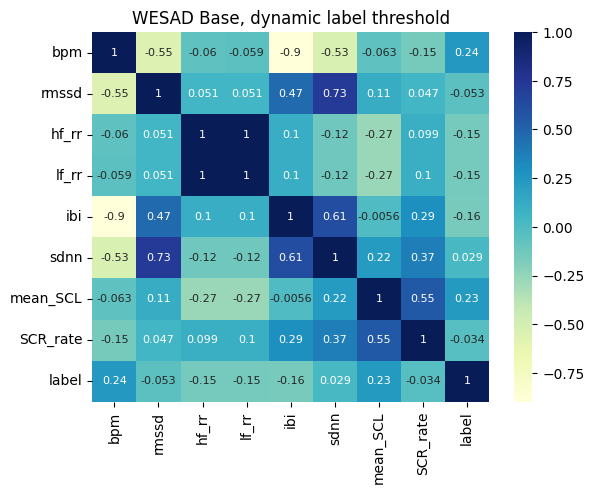

TSST ------------------------------
         bpm     rmssd     hf_rr     lf_rr       ibi      sdnn  mean_SCL  \
0   0.000000  0.506172  0.026251  0.030673  0.949664  0.154841  0.258824   
1   0.093852  0.371645  0.250774  0.247178  1.000000  0.530232  0.442462   
2   0.239614  0.089189  0.004130  0.002209  0.746574  0.258758  0.639081   
3   0.141417  0.716031  1.000000  1.000000  0.917887  0.556925  0.624106   
4   0.283424  1.000000  0.389416  0.386918  0.762746  0.857614  1.000000   
5   0.345026  0.308206  0.033757  0.029421  0.612077  0.528280  0.458818   
6   0.184863  0.803080  0.013936  0.005310  0.618439  0.535540  0.786124   
7   0.725463  0.592836  0.019538  0.018465  0.239807  1.000000  0.000000   
8   0.941519  0.000000  0.395530  0.388241  0.033782  0.000000  0.548076   
9   0.658288  0.293354  0.074677  0.068716  0.262690  0.415662  0.886796   
10  0.983282  0.036097  0.177465  0.170742  0.012898  0.103235  0.726694   
11  0.237638  0.246819  0.000000  0.000000  0.774410

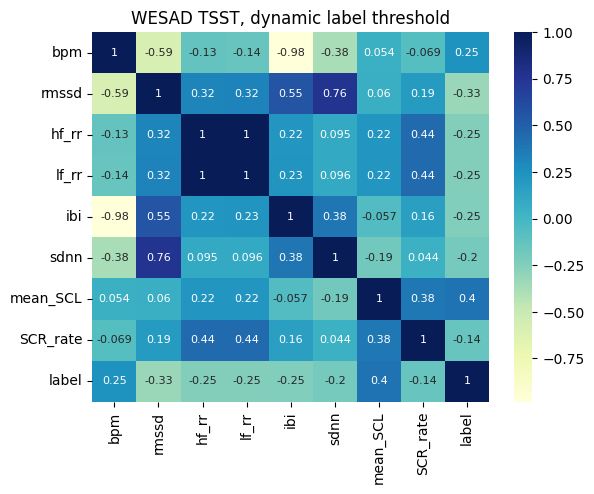

Medi_1 ------------------------------
         bpm     rmssd     hf_rr     lf_rr       ibi      sdnn  mean_SCL  \
0   0.362584  0.403554  0.008658  0.013019  0.602451  0.261728  0.023481   
1   0.107862  0.576121  0.103423  0.132584  0.557072  0.794617  0.000000   
2   0.147406  0.000000  0.002995  0.004341  0.235517  0.117179  0.034639   
3   0.519494  0.390352  1.000000  1.000000  0.460957  0.531608  0.048075   
4   0.000000  0.545288  0.001235  0.002430  1.000000  1.000000  0.085861   
5   0.290811  0.521202  0.104937  0.147210  0.674980  0.889969  0.050955   
6   0.529169  0.082190  0.000000  0.000000  0.454529  0.188338  0.057881   
7   0.610387  0.221906  0.004334  0.005578  0.389702  0.469669  0.065080   
8   0.903054  0.175665  0.027301  0.036887  0.187410  0.415624  0.115363   
9   0.804490  0.234001  0.001278  0.001289  0.258074  0.470895  0.086260   
10  0.889636  0.037156  0.087615  0.123223  0.196291  0.149249  0.093875   
11  0.509380  0.118093  0.032138  0.045719  0.4716

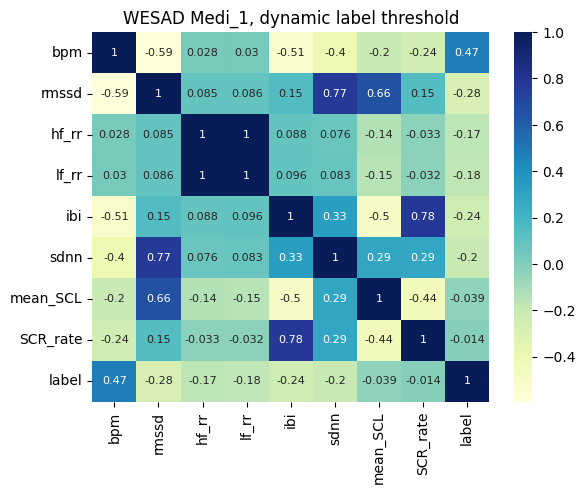

Fun ------------------------------
         bpm     rmssd     hf_rr     lf_rr       ibi      sdnn  mean_SCL  \
0   0.175926  0.540008  0.119235  0.143745  0.762246  0.694407  0.258448   
1   0.053341  0.422385  0.062922  0.053958  0.937674  0.731990  0.171954   
2   0.188178  0.055492  0.014281  0.016336  0.579141  0.426923  0.241577   
3   0.184374  0.166622  0.025796  0.017799  0.802130  0.000000  0.305903   
4   0.000000  0.436510  0.165520  0.169467  1.000000  0.557190  0.473892   
5   0.451591  0.431979  0.010115  0.009837  0.574884  1.000000  0.487570   
6   0.671394  0.000000  0.077079  0.078106  0.442375  0.021453  0.359924   
7   0.743799  1.000000  0.002007  0.000046  0.000000  0.981567  0.404494   
8   0.371788  0.386636  1.000000  1.000000  0.601041  0.797162  0.715269   
9   1.000000  0.576092  0.003610  0.002915  0.298427  0.358985  0.000000   
10  0.785210  0.138133  0.016165  0.013069  0.283080  0.021133  0.570738   
11  0.494519  0.002792  0.000000  0.000000  0.557389 

KeyboardInterrupt: 

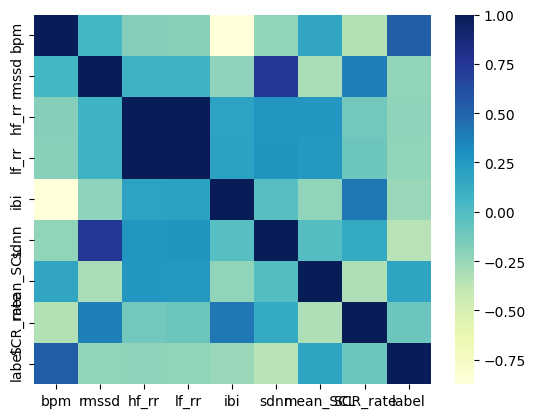

In [6]:
# VISUALIZING FEATURES -- correlation between mean of all features for each phase 
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dr_w)
importlib.reload(dt)
importlib.reload(train)
import seaborn as sb

threshold = "dynamic"


# phases = dr_a.Phases.PHASES_LIST
# apd_label_type = "Anxiety"

# for i, phase in enumerate(phases):
#     print(f"{phase} " + "-"*30)
#     x, y = train.Train_APD.get_apd_data_ranking(metrics, [phase], verbose=False, anxiety_label_type=apd_label_type, threshold=threshold)
#     x = pd.concat([x, y], axis=1)
#     heat_map = sb.heatmap(x.loc[:, metrics + ["label"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontsize":8})
#     plt.title(f"APD {phase}, {threshold} label threshold")
#     plt.show()


phases = dr_w.Phases.PHASE_ORDER
wesad_label_type = "stai"

for i, phase in enumerate(phases):
    print(f"{phase} " + "-"*30)
    x, y = train.Train_WESAD.get_wesad_data(metrics, [phase], verbose=False, label_type=wesad_label_type, normalize=True, threshold=threshold)
    x = pd.concat([x, y], axis=1)
    heat_map = sb.heatmap(x.loc[:, metrics + ["label"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontsize":8})
    plt.title(f"WESAD {phase}, {threshold} label threshold")
    plt.show()

# popane_studies = {
#     "Study1": dr_p.Study1.ALL,
#     "Study2": dr_p.Study2.ALL,
#     "Study3": dr_p.Study3.ALL,
#     # "Study4": dr_p.Study4.ALL,
#     "Study5": dr_p.Study5.ALL,
#     # "Study6": dr_p.Study6.ALL,
#     # "Study7": dr_p.Study7.ALL
# }
# popane_label_type = "affect"

# for study in popane_studies.keys():
#     phases = popane_studies[study]
#     for i, phase in enumerate(phases):
#         print(f"{phase} " + "-"*30)
#         try:
#             x, y = train.Train_POPANE.get_popane_data(study, metrics, [phase], verbose=False, label_type=popane_label_type, threshold=threshold)
#         except Exception as e:
#             print(f"Unable to load data for {study} {phase}")
#             continue
#         x = pd.concat([x, y], axis=1)
#         heat_map = sb.heatmap(x.loc[:, metrics + ["label"]].corr(), cmap="YlGnBu", annot=True, annot_kws={"fontsize":8})
#         plt.title(f"POPANE {study}, {phase}, {threshold} label threshold")
#         plt.show()